**Importing Packages**

In [22]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16
from keras import backend as K

In [2]:
train_data=ImageDataGenerator(rescale=1.0/255)
test_data=ImageDataGenerator(rescale=1.0/255)

In [3]:
train=train_data.flow_from_directory("C:/Users/akash/Downloads/study/cg/dataset/chest_xray/train",target_size=(128,128),class_mode='categorical',batch_size=32,shuffle=True)
test=test_data.flow_from_directory("C:/Users/akash/Downloads/study/cg/dataset/chest_xray/test",target_size=(128,128),class_mode='categorical',batch_size=32,shuffle=True)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Train set:
PNEUMONIA=3883
NORMAL=1349
Test set:
PNEUMONIA=390
NORMAL=234


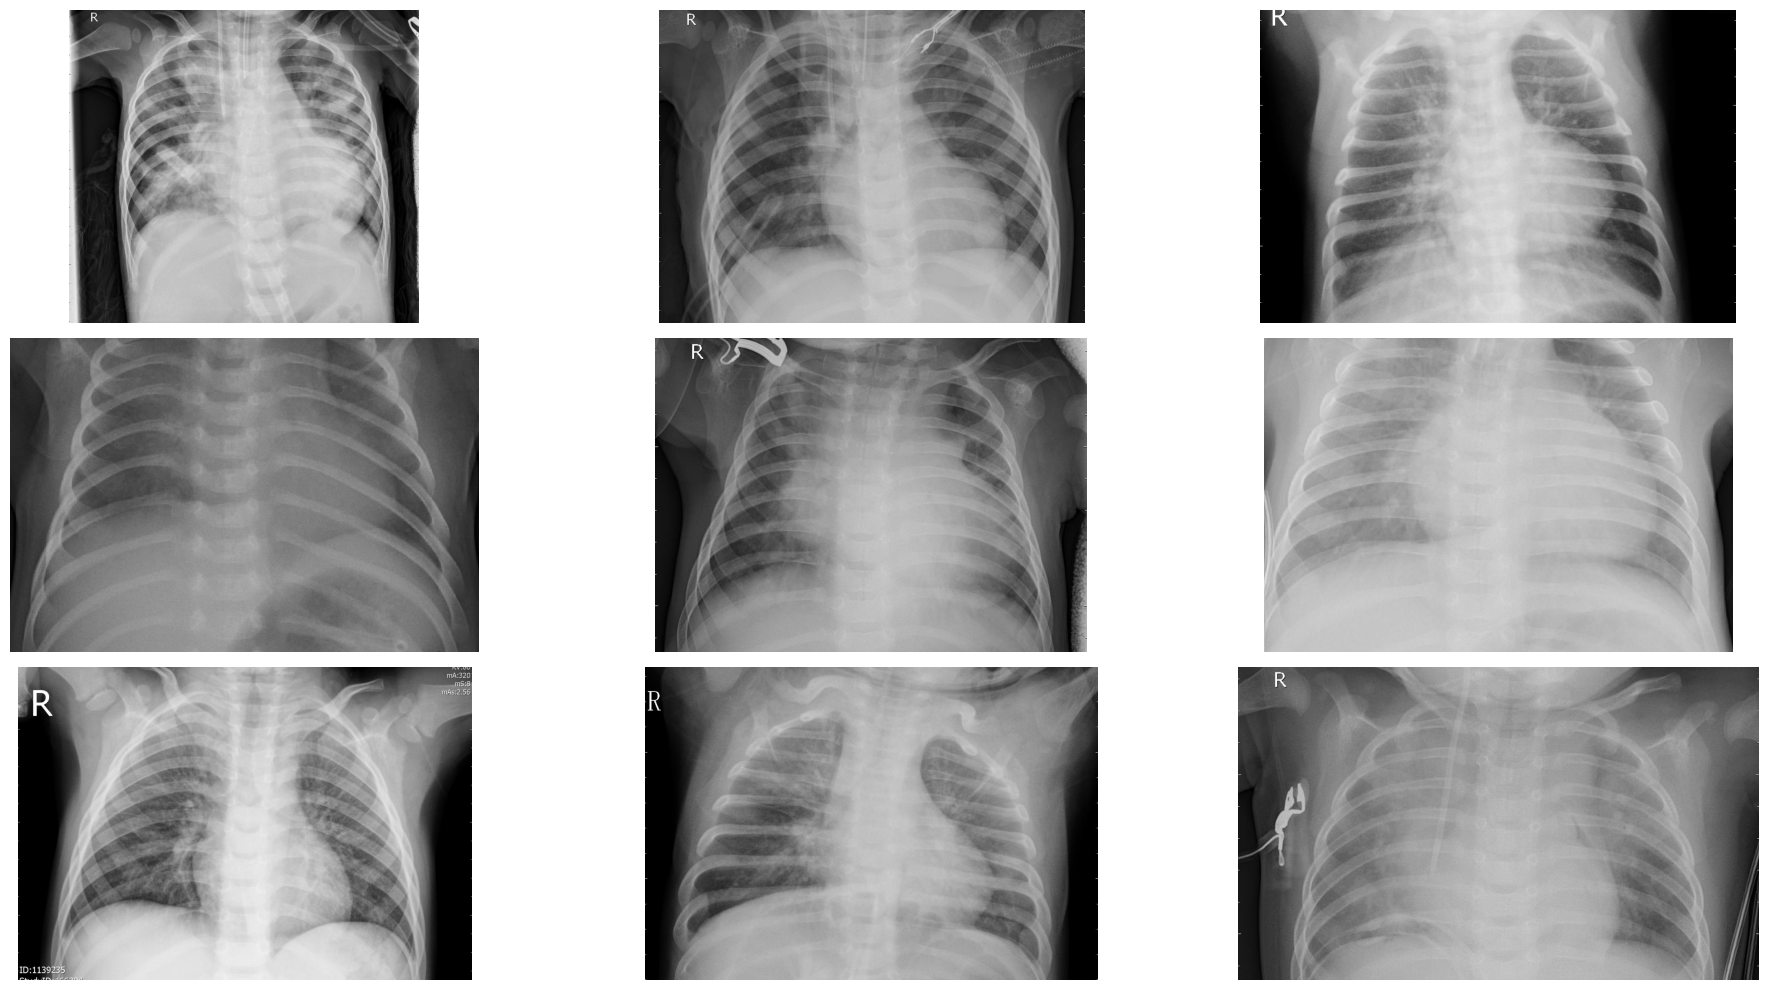

In [4]:
train_dir = "C:/Users/akash/Downloads/study/cg/dataset/chest_xray/train"
test_dir = "C:/Users/akash/Downloads/study/cg/dataset/chest_xray/test"


print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")


pneumonia = os.listdir("C:/Users/akash/Downloads/study/cg/dataset/chest_xray/train/PNEUMONIA")
pneumonia_dir = "C:/Users/akash/Downloads/study/cg/dataset/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

**Considering a Single Image**

The dimensions of the image are 2476 pixels width and 2572 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 120.9381 and the standard deviation is 60.4879


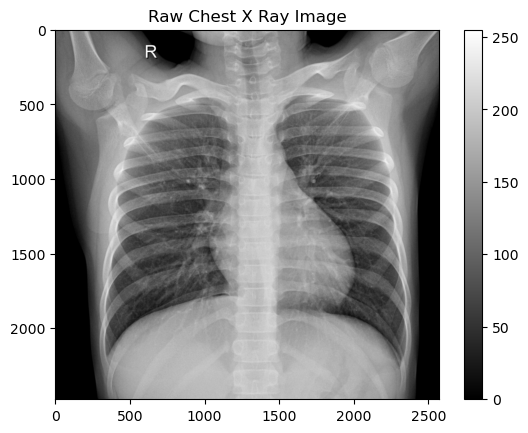

In [5]:
normal_img = os.listdir("C:/Users/akash/Downloads/study/cg/dataset/chest_xray/train/NORMAL")[0]
normal_dir = "C:/Users/akash/Downloads/study/cg/dataset/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel.
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.4917 and the standard deviation is 0.2332


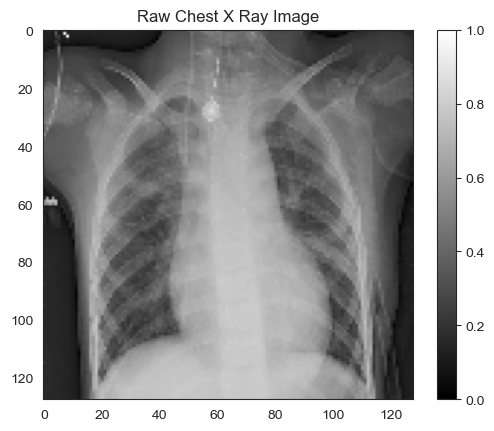

In [6]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

**Pixel Value Distribution**

Text(-9.930555555555555, 0.5, '# Pixels in Image')

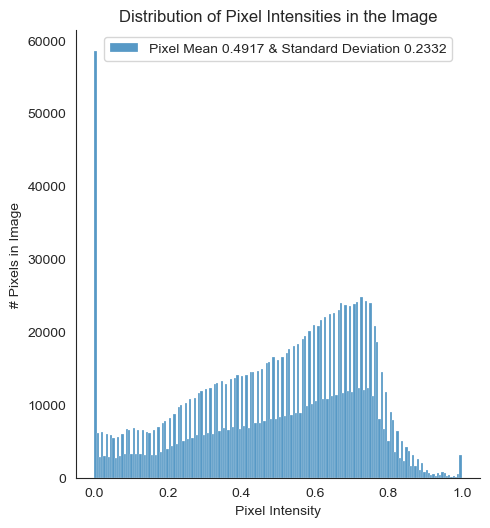

In [7]:
sns.displot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

**Image Processing**

In [8]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

**Building Separate Generator**

In [9]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(test_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Model Building**

In [10]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")


Weight for class 0: 0.74
Weight for class 1: 0.26


In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 176, 176, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                        

In [14]:
r = model.fit(
    train, 
    epochs=10,
    class_weight=class_weight,
)

Epoch 1/10
654/654 [==============================] - 514s 783ms/step - loss: 0.2888 - accuracy: 0.8651
Epoch 2/10
654/654 [==============================] - 508s 776ms/step - loss: 0.0955 - accuracy: 0.9031
Epoch 3/10
654/654 [==============================] - 508s 776ms/step - loss: 0.0890 - accuracy: 0.9188
Epoch 4/10
654/654 [==============================] - 507s 775ms/step - loss: 0.1016 - accuracy: 0.8977
Epoch 5/10
654/654 [==============================] - 508s 776ms/step - loss: 0.0847 - accuracy: 0.9218
Epoch 6/10
654/654 [==============================] - 505s 772ms/step - loss: 0.1015 - accuracy: 0.9123
Epoch 7/10
654/654 [==============================] - 504s 770ms/step - loss: 0.0787 - accuracy: 0.9157
Epoch 8/10
654/654 [==============================] - 507s 776ms/step - loss: 0.0694 - accuracy: 0.9258
Epoch 9/10
654/654 [==============================] - 517s 791ms/step - loss: 0.0811 - accuracy: 0.9258
Epoch 10/10
654/654 [==============================] - 534s 817m

Text(0.5, 1.0, 'Accuracy Evolution')

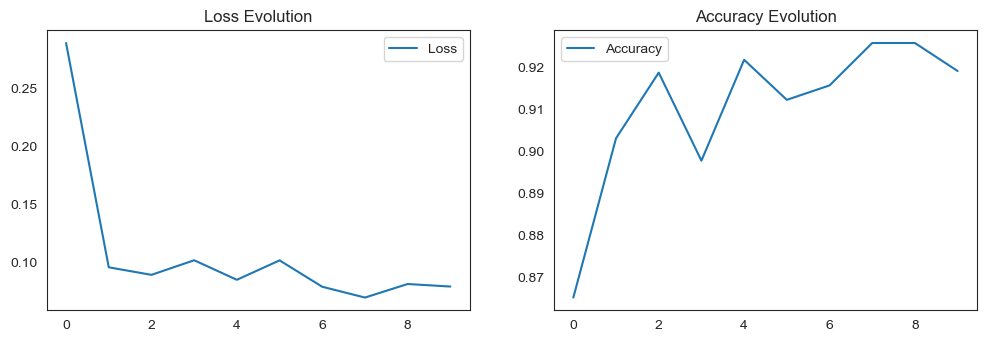

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [17]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 26s 41ms/step - loss: 0.2751 - accuracy: 0.9071
Test Accuracy: 90.71%
654/654 [==============================] - 165s 252ms/step - loss: 0.1688 - accuracy: 0.9308
Train Accuracy: 93.08%


In [20]:
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 [==============================] - 25s 40ms/step
[[191  43]
 [ 20 370]]


,0,1,accuracy,macro avg,weighted avg
precision,0.905213,0.895884,0.899038,0.900549,0.899382
recall,0.816239,0.948718,0.899038,0.882479,0.899038
f1-score,0.858427,0.921544,0.899038,0.889986,0.897875
support,234.000000,390.000000,0.899038,624.000000,624.000000


In [21]:
print(test.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

**VGG16**


In [ ]:
# VGG16 model
vgg=VGG16(input_shape=image_size+[3],weights='imagenet',include_top=False)

In [ ]:
# As all the layers are trained already
for layer in vgg.layers:
    layer.trainable=False

In [ ]:
folder= glob("C:/Users/akash/Downloads/study/cg/dataset/chest_xray/train")

In [ ]:
vgg16_base_model.summary()

In [25]:
 vgg16_model = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

In [28]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
vgg16_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)


In [29]:
r = vgg16_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)

Epoch 1/10
100/100 [==============================] - 347s 3s/step - loss: 0.2587 - accuracy: 0.6800 - precision: 0.8821 - recall: 0.6560 - val_loss: 2.7943e-09 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 341s 3s/step - loss: 0.2067 - accuracy: 0.7287 - precision: 0.9056 - recall: 0.6972 - val_loss: 9.3845e-08 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 339s 3s/step - loss: 0.2020 - accuracy: 0.7550 - precision: 0.9196 - recall: 0.7268 - val_loss: 0.1517 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 341s 3s/step - loss: 0.1822 - accuracy: 0.7450 - precision: 0.9287 - recall: 0.7227 - val_loss: 0.0468 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 340s 3

In [31]:
vgg16_model.save('pneumonia_vgg16')

INFO:tensorflow:Assets written to: pneumonia_vgg16\assets


INFO:tensorflow:Assets written to: pneumonia_vgg16\assets


Text(0.5, 1.0, 'Accuracy Evolution')

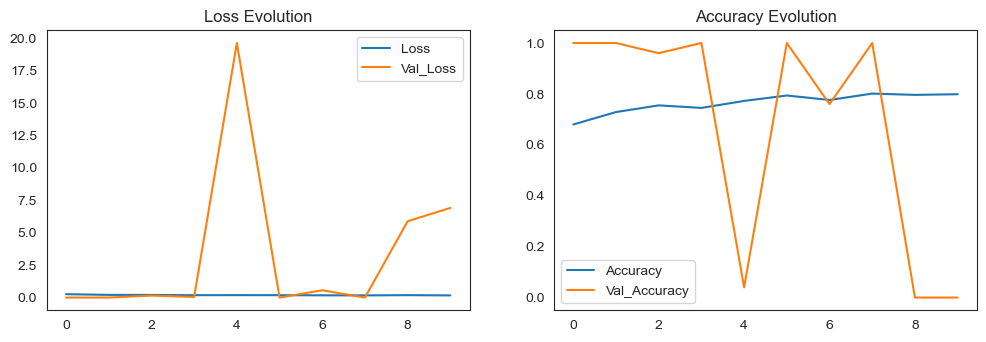

In [33]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [34]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 74s 119ms/step - loss: 2.5283 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Test Accuracy: 62.50%
654/654 [==============================] - 566s 865ms/step - loss: 1.5451 - accuracy: 0.7422 - precision: 0.7422 - recall: 1.0000
Train Accuracy: 74.22%
